# Druk, temperatuur en energie

## Doelen

Om het gedrag van een gas beter te begrijpen moeten we de microscopische eigenschappen van ons model (zoals massa, snelheid, impuls en energie per deeltje) nu verbinden aan de macroscopische eigenschappen van het systeem (zoals druk en temperatuur).
We gaan ons model dus uitbreiden met code om deze macroscopische eigenschappen te berekenen.

Eerst nemen we alle delen over van de code die we opnieuw moeten gebruiken:
- class voor particles
- functies voor detecteren botsingen
- (toelichten van een snellere manier van programmeren).

Daarna voegen we de code toe voor de nieuwe macroscopische eigenschappen:
- een functie schrijven voor de temperatuur
- een functie schrijven voor de druk

En dan maken we een simulatie, controleren we de resultaten en verbeteren we eventueel de code. 

## Externe bronnen
Bij het maken van deze module kun je de Feynman lectures on Physics erg goed gebruiken.
We bevelen aan:
- [The Kinetic Theory of Gases](https://www.feynmanlectures.caltech.edu/I_39.html) voor het afleiden van de druk, en het botsingsmodel.


## Laden van alle code die we al ontwikkeld hebben

Eerst roepen we de juiste pakketten van Python aan en bepalen we de waardes van de constanten van onze simulatie.

```{exercise}
Neem de constanten die je in het vorige werkblad hebt gekozen hieronder over.
```

In [104]:
# ruimte voor uitwerking

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

BOX_SIZE_0 = 10 #m^2   (dus 10 meter lang, en 10 meter breed)                # Hoogte en breedte startvolume (in vul je gekozen eenheid in)
N = 40                          # Aantal deeltjes 
V_0 =           411 #m/s               # Startsnelheid van deeltjes (vul je gekozen eenheid in)
RADIUS =        0.3 #m                # Straal van moleculen
DT = 1/2000 #s                          # Tijdstap om geen botsing te missen

# met deze waarden ( die niet zo realistisch zijn) werkt de simulatie goed en snel.


De klasse voor de gasmoleculen en de functies voor hun onderlinge interactie:

In [105]:
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = R

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    dx = p1.r[0] - p2.r[0]
    dy = p1.r[1] - p2.r[1]
    rr = p1.R + p2.R
    return  dx**2+dy**2 < rr**2 

def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)

    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return

    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

Het volume met de 'oude' randvoorwaarden. Dit zijn niet de randvoorwaarden van het vorige werkblad, maar de randvoorwaarden die je eerder hebt gebruikt. Hierbij botsen de deeltjes elastisch met de wanden van het volume. 

In [106]:
def box_collision(particle: ParticleClass):
    ''' botsing met harde wanden '''
    if abs(particle.r[0]) + particle.R > BOX_SIZE_0/2: 
        particle.v[0] = -particle.v[0]                                        # Omdraaien van de snelheid
        particle.r[0] = np.sign(particle.r[0]) * (BOX_SIZE_0/2 - particle.R)  # Zet terug net binnen box                 
    if abs(particle.r[1]) + particle.R > BOX_SIZE_0/2: 
        particle.v[1] = -particle.v[1]     
        particle.r[1] = np.sign(particle.r[1]) * (BOX_SIZE_0/2 - particle.R) 

Het uitvoeren en samennemen van deze functies over een lijst met deeltjes:

In [107]:
def create_particles(particles):
    """ Leegmaken en opnieuw aanmaken van deeltjes  in lijst """
    particles.clear()
    for i in range(N):
        vx = np.random.uniform(-V_0, V_0)
        vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
        pos = np.random.uniform(-BOX_SIZE_0/2 + RADIUS, BOX_SIZE_0/2 - RADIUS, 2)
        particles.append(ParticleClass(m=4.81*10**-26, v=[vx, vy], r=pos, R=RADIUS))

# note dat deze handle_collisions functie anders is dan we gedaan in brownian motion
# controleer zelf welke van de twee functies sneller is (wat, zoals gezegd, sterk afhangt van het aantal deeltjes!)
def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])

def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst """
    for p in particles:
        box_collision(p)

# de eigenlijke stappen in de simulatie
def take_time_step(particles):
    """ zet tijdstap voor een lijst deeltjes en verwerk alle botsingen onderling en met wanden """
    for p in particles:
        p.update_position()
    handle_collisions(particles)
    handle_walls(particles)  


## Het draaien van een eerste simulatie ter controle

Laten we het eerst zo eenvoudig mogelijk maken en controleren of het lukt om honderd tijdstappen te zetten met de hierboven gedefinieerde functies. 
Als resultaat beperken we ons tot het plotten van de posities van de deeltjes en hun snelheden.

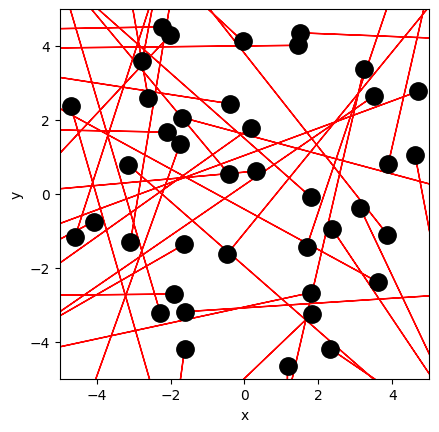

In [108]:
particles = []
create_particles(particles)

# doorlopen van de simulatie
for i in range(100):
    take_time_step(particles)

# plotten van de positie van de deeltjes en hun snelheid als vector
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
plt.ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)

for p in particles:
    plt.plot(p.r[0], p.r[1], 'k.', ms=25)
    plt.arrow(p.r[0], p.r[1], p.v[0], p.v[1], 
              head_width=0.05, head_length=0.1, color='red')
plt.show()

## Temperatuur

Het boek behandelt de microscopische formules helemaal niet, maar de thermische energie van een gas is niets anders dan de statistisch gemiddelde kinetische energie van de deeltjes waaruit het gas bestaat.
Nu is er van alles te zeggen over deze statistiek, maar voor nu gaan we daar even aan voorbij.
Dat is onderwerp van het volgende werkblad.

De temperatuur wordt gegeven door:

$$
    \frac{f}{2}kT=\frac{1}{2}m\left<v^2\right>
$$

Hierbij is 

- $k$ de constante van Boltzmann ($1.380649\times10^{-23} \mathrm{ JK}^{-1}$)
- $f$ het aantal vrijheidsgraden (het aantal dimensies waarin het gas kan bewegen)
- $T$ de temperatuur (in $\mathrm{kelvin}$)
- $m$ de massa van de deeltjes (in $\mathrm{kg}$)
- $v$ de snelheid van de deeltjes (in $\mathrm{ms}^{-1}$)

```{exercise} Temperatuurfunctie
:label: ex-drukdremp-1

Schrijf een functie die de temperatuur van het gas in onze simulatie bepaalt:
```

In [109]:
def temperature(particles) -> float:
    temp = 0.0 
    mean_kin_energy = sum(p.kin_energy for p in particles)/ N
    temp = mean_kin_energy / (1.380649*10**-23)
    return temp

print(temperature(particles))




294.2493023208649


```{exercise} Temperatuurplot
:label: ex-druktemp-2

Gebruik deze functie om een simulatie te maken waarin je de temperatuur als functie van de tijdstap voor 100 tijdstappen plot.
```

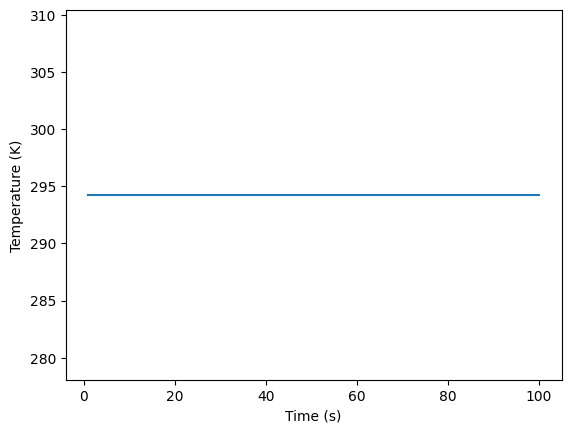

In [110]:
# ruimte voor uitwerking

particles = []
temperatures = np.zeros(100, dtype=float)
times = np.linspace(1, 100, 100)

create_particles(particles)

for i in range(100):
    take_time_step(particles)
    temp_tijd = temperature(particles)
    temperatures[i] = temp_tijd


plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.plot(times, temperatures)
plt.show()

```{exercise}
:label: ex-druktemp-3

De assen moeten natuurlijk ook eenheden hebben.
In een vorige module heb je de vermenigvuldigingsfactoren en eenheden bij de constanten van deze simulatie bepaald.
- Breid de berekening uit, zodat de eenheden kloppen bij het model dat we probeerden weer te geven.

zie hierboven de grafiek
```

## Druk

De druk van een gas is lastiger te berekenen dan de temperatuur.
Het is letterlijk de druk van de gasmoleculen tegen de wanden van het volume. 

$$ 
    P = \frac{F}{A} \stackrel{2D}{=} \frac{F}{l} = \frac{dp / dt}{l} \approx \frac{\Delta p}{l\Delta t} 
$$

Hierbij is:

- $P$ de druk (hoofdletter om te onderscheiden t.o.v. impuls)
- $A$ het oppervlak van de wand (voor de 3D situatie)
- $l$ de lengte van de wand (voor de 2D situatie)
- $p$ de impuls van het gasdeeltje

In de laatste stap hebben we de afgeleide vervangen door het verschil over een tijdstap, omdat die informatie makkelijk uit onze simulatie te halen is.
Om de druk op de wand te bepalen, moeten we dus de verandering van de impuls van de wand bepalen.
In het Nederlands wordt de verandering van impuls ook wel 'stoot' genoemd.
Onhandig is dat de Engelse term hiervoor 'impulse' is.

De wand in ons experiment staat natuurlijk stil, maar ook hier geldt de wet van behoud van impuls (let op: dit is de Nederlandse impuls, die in het Engels 'momentum' heet).
We kunnen dus kijken naar de verandering van impuls van de moleculen op het moment dat deze botsen met de wand.
Daarvoor maken we een nieuwe versie van de functie `handle_walls` die voor het afhandelen van deze botsing wordt aangeroepen.

We kiezen ervoor om de botsingen met de wanden hierbij te splitsen in twee functies: eentje voor de verticale wanden en een voor de horizontale wanden.
Dat lijkt nu nog wat overdreven, maar als het model straks verder wordt uitgebreid houdt dit de code het meest overzichtelijk.

```{note}
Let op het gebruik van variabelen en het gebied waarbinnen ze gelden (genaamd 'scope'). In de functie `handle_walls` wordt gebruik gemaakt van een variabele `p`. Deze variabele heeft alleen een waarde binnen de functie. Als je de variabele `p` buiten de functie `handle_walls` aanroept wordt daar een nieuw geheugenadres voor gereserveerd met een waarde die niet gerelateerd is met de waarde binnen de functie `handle_walls`. Als je wil dat die waarde buiten en binnen de functie dezelfde is, dan moet je dit aan Python uitleggen. Het benoemen van een variabele met het keyword `global` zorgt hiervoor.

Programmeurs proberen het aantal globale variabelen te reduceren tot een minimum. Bij grote programma's wordt het aantal variabelen namelijk snel onoverzichtelijk. We komen hier in een later werkblad op terug. 
```

In [179]:
impulse_outward = 0.0
pressure = 0.0

def top_down_collision(particle: ParticleClass):
    global impulse_outward
    if abs(particle.r[1]) + particle.R > BOX_SIZE_0 / 2:
        particle.r[1] = np.sign(particle.r[1]) * (BOX_SIZE_0/2 - particle.R)
        impulse_outward += abs(particle.momentum[1]) * 2
        particle.v[1] *= -1
    
def left_right_collision(particle: ParticleClass):
    global impulse_outward
    if abs(particle.r[0]) + particle.R > BOX_SIZE_0 / 2:
        particle.r[0] = np.sign(particle.r[0]) * (BOX_SIZE_0/2 - particle.R)
        impulse_outward += abs(particle.momentum[0]) * 2
        particle.v[0] *= -1
    
def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst en bepaling druk """
    global pressure, impulse_outward       # om pressure buiten de functie te kunnen gebruiken
    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)
    pressure = (impulse_outward) / (4 * BOX_SIZE_0 * DT)  # omtrek volume is oppervlak (2D sim)


```{exercise}
:label: ex-druktemp-4
Maak nu een simulatie waarin je de druk als functie van de tijd toont gedurende 100 tijdstappen.

Je zal zien dat deze grafiek niet een mooie vlakke vorm zal hebben.
Wat zou je als verklaring hiervoor geven?
```
Het zijn weinig deeltjes, waardoor het resultaat chaotischer is.

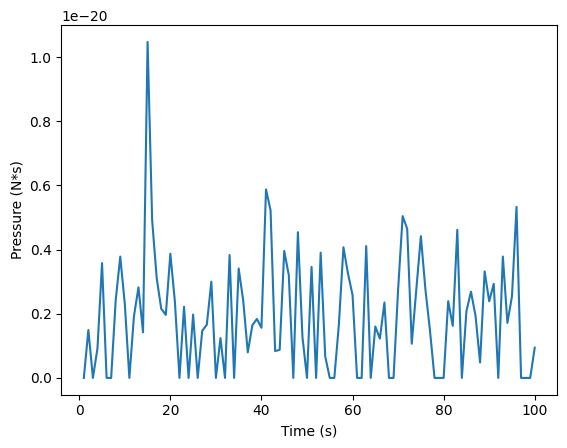

In [159]:

# N=400
# BOX_SIZE_0 = 15 #m^2  

particles = []
pressures = np.zeros(100, dtype=float)
times = np.linspace(1, 100, 100)

create_particles(particles)

for i in range(100):
    take_time_step(particles)
    pressures[i] = pressure

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Pressure (N*s)')
plt.plot(times, pressures)
plt.show()

## Verbeteren van code: middelen

De grafiek voor de druk bestaat uit een achtergrond op de waarde 0 en daarop een serie scherpe pieken.
Een piek komt overeen met een tijdstap waar er toevallig een atoom met de wanden botst.
Om deze grafiek meer constant te maken kunnen we het aantal deeltjes sterk verhogen door een veel groter volume te modelleren, maar dat kost ons veel meer rekenkracht.

```{exercise}
:label: ex-druktemp-5
Probeer bovenstaande simulatie uit te voeren met 400 deeltjes, vergeet niet je volume ook aan te passen (wat zou anders het gevolg zijn).

Klaar?
Zet je initiële waarden weer terug.
```

Een goedkoper alternatief bestaat uit het middelen van de druk over de tijd.
Fysisch is daar geen echte reden voor, maar ook meetinstrumenten in het laboratorium bepalen hun meetwaarde gedurende een tijdsinterval om hun ruis te verlagen. 

In de code doen we dit door de druk in de $i$-de tijdstap ($P_i$) niet volledig te laten bepalen door de druk tijdens de tijdstap waarin de simulatie plaatsvindt ($P$), maar door de druk in de vorige tijdstap ($P_{i-1}$) mee te nemen. 

$$ 
    P_{i} = \alpha * P + (1-\alpha) * P_{i-1}
$$

Door de factoren op deze manier netjes te kiezen, verandert de netto waarde voor de druk niet want voor $|\alpha| < 1$ geldt:

$$ 
    \sum_{i=0}^{\infty}(\alpha^k)(1-\alpha) =  \frac{1}{1-\alpha}(1-\alpha) = 1 
$$ (int_norm)

Merk op dat een waarde $\alpha=1$ ons weer terugbrengt bij een simulatie voor de druk zonder exponentieel voortschrijdend gemiddelde.
Daarbij, kleine waarden voor $\alpha$ (0.01-0.1) leveren sterke demping op.
Het signaal wordt 'smooth' maar reageert traag op veranderingen in de echte druk. 
Voor grotere waarden voor $\alpha$ geldt dat er weinig demping is.

In [187]:
def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst en gemiddeld bepaling druk """
    global pressure, impulse_outward       # om pressure buiten de functie te kunnen gebruiken
    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)    
    alpha = 0.1
    pressure = alpha * impulse_outward / (4 * BOX_SIZE_0 * DT) + (1-alpha) * pressure # omtrek volume is oppervlak (2D sim)

```{exercise}
Kopieer nu je code voor de simulatie waarin je de druk als functie van de tijd hebt geplot naar onderstaand veld en voer de simulatie nogmaals uit met de nieuwe definitie voor de functie `handle_walls`.
```

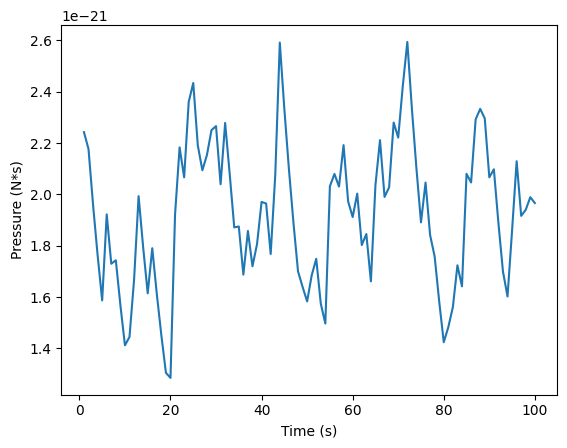

In [188]:
# RUIMTE VOOR GEKOPIEERDE FUNCTIE
N=40
BOX_SIZE_0 = 10 #m^2   

particles = []
pressures = np.zeros(100, dtype=float)
times = np.linspace(1, 100, 100)

create_particles(particles)

for i in range(100):
    take_time_step(particles)
    if handle_walls:
        pressures[i] = pressure

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Pressure (N*s)')
plt.plot(times, pressures)
plt.show()


Met de middeling kan je beter zien wat de gemiddelde waarde voor de druk in dit systeem is. Als dit voor jouw simulatie lastig is kan je de factor `alpha` aanpassen in de functie 'handle_walls`, zodat je over een langere periode het gemiddelde neemt. Hou daarbij wel rekening met de eis in [bovenstaande formule](int_norm)

```{exercise}
:label: ex-druktemp-7
We kunnen de gevonden druk nu wel uitdrukken in SI-eenheden met behulp van de voorfactoren die we voor de constanten hebben gevonden, maar daar komt niet de 10 bar uit van de fietsband die we wilden modelleren. Kan je verklaren waardoor dit komt?
```

```{solution} ex-druktemp-7
#your code/answer
```

```{exercise}
:label: ex-druktemp-8

De techniek die we hierboven hebben toegepast wordt *exponentieel voortschrijdend gemiddelde* genoemd.
Leg op basis van de vormen die je ziet en de bijbehorende wiskunde uit dat dit een logische naamgeving is.
```

```{solution} ex-druktemp-8
#your code/answer
```

Om te voorspellen welke waarde de druk hier dan wel krijgt, moeten we de formule verder ontwikkelen. We hebben al gezien dat de druk ten gevolge van de stoot op de wand werd gegeven door:

$$
    P = \frac{\Delta p}{l\Delta t} = \frac{2mv_x}{l\Delta t}
$$

We moeten dit natuurlijk over alle deeltjes sommeren, maar ook bepalen hoe vaak een deeltje in de tijd meedoet. De $\Delta t$ in bovenstaande formule wordt dan de tijd tussen twee botsingen voor een enkel deeltje (=$2l/v_x$). Dan is de druk voor alle deeltjes samen:

$$
    \left< P \right> = \sum_{i=1}^{N} \frac{2mv_{x,i}}{l (2l/v_{x,i})} = \frac{m}{l^2} \sum_{i=1}^{N} v_{x,i}^2 = \frac{mN}{A} \left< v_x^2\right>
$$

Omdat het systeem geen voorkeur heeft voor snelheden in de $x$ of de $y$-richting kunnen we stellen dat $\left< v_x^2 \right> = \left< v_y^2 \right> $, zodat in twee dimensies geldt dat $\left< v_x^2 \right> = \frac{1}{2} \left< v^2 \right>$. Daarmee moet de waarde voor de druk dus gelijk zijn aan:

$$
    \left< P \right> = \frac{mN}{A} \frac{\left< v^2\right>}{2}
$$ (2d_pressure)

```{exercise} 
:label: ex-druktemp9a

Controleer of je uitkomst overeenkomt met de theorie en verifieer hiermee de code.
```

In [de formule voor de tweedimensionale druk](2d_pressure) kan je de structuur van de ideale gaswet herkennen. 

```{exercise}
:label: ex-druktemp9b

Herleid dezelfde formule af voor het driedimensionale geval. Laat zien welke relatie er geldt tussen de constanten voor het macroscopische (thermodynamische) model en het microscopische (mechanische) model.
```

```{solution} ex-druktemp9b
Geef hier de relatie tussen de constanten...
#your code/answer
```

```{exercise}
:label: ex-druktemp-12
Laat je werk aftekenen door een TA en besluit of je eventueel wil doorgaan met de verdiepende opdracht voor een 'excellent' op dit onderdeel.
```

```{exercise} 🌶 Uitbreiding
:label: ex-druktemp-13
Je ziet dat de druk een statistisch bepaalde grootheid is die met de tijd varieert. Het is interessant om dit te onderzoeken.

- Maak een histogram van de drukwaardes die je meet gedurende een simulatie.
- Maak de lengte van de simulatie lang genoeg zodat dit histogram op het oog voldoende reproduceert.
- Bepaal de breedte van de verdeling van drukwaardes met een eigen gekozen definitie.
- Verhoog het aantal deeltjes met een factor twee en herhaal je berekening.
- Schat hieruit de statistische variatie in de druk bij een volume met $10^{23}$ deeltjes.
